<a href="https://colab.research.google.com/github/prabindebnath25/NYC-Taxi-Trip-Time-Prediction/blob/main/NYC_Taxi_Trip_Time_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

In [209]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from geopy import distance

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge,ElasticNet
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Importing the dataset

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
path = "/content/drive/MyDrive/regression capstone project/NYC Taxi Data.csv"
df1 = pd.read_csv(path)

In [51]:
df = df1.iloc[:100000]

In [52]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


# EDA


In [53]:
df.shape

(100000, 11)

In [54]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.53349,1.667810,-73.973464,40.751059,-73.973455,40.751947,939.864260
std,0.49888,1.317603,0.038294,0.028152,0.036625,0.032452,3004.541199
min,1.00000,0.000000,-74.533875,40.433842,-74.562355,40.441662,1.000000
25%,1.00000,1.000000,-73.991852,40.737370,-73.991394,40.735844,396.000000
50%,2.00000,1.000000,-73.981712,40.754269,-73.979782,40.754478,662.000000
75%,2.00000,2.000000,-73.967209,40.768426,-73.962919,40.769928,1076.000000
max,2.00000,6.000000,-73.334023,41.319164,-72.711395,41.311520,86390.000000


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  100000 non-null  object 
 1   vendor_id           100000 non-null  int64  
 2   pickup_datetime     100000 non-null  object 
 3   dropoff_datetime    100000 non-null  object 
 4   passenger_count     100000 non-null  int64  
 5   pickup_longitude    100000 non-null  float64
 6   pickup_latitude     100000 non-null  float64
 7   dropoff_longitude   100000 non-null  float64
 8   dropoff_latitude    100000 non-null  float64
 9   store_and_fwd_flag  100000 non-null  object 
 10  trip_duration       100000 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 8.4+ MB


In [56]:
df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [57]:
df.drop(columns= ['id'], inplace= True)

In [58]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

In [59]:
df['weekday'] = df['pickup_datetime'].dt.weekday
df['month'] = df['pickup_datetime'].dt.month

df.drop(columns=['pickup_datetime', 'dropoff_datetime'], inplace= True)

In [60]:
df.store_and_fwd_flag.value_counts()

N    99416
Y      584
Name: store_and_fwd_flag, dtype: int64

In [61]:
df.columns

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'weekday', 'month'],
      dtype='object')

In [62]:
df.vendor_id.value_counts()

2    53349
1    46651
Name: vendor_id, dtype: int64

## trip duration

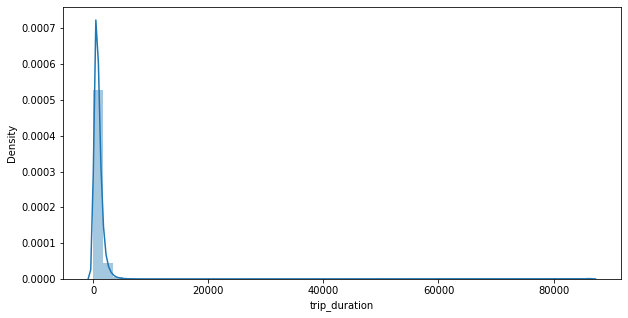

In [63]:
plt.figure(figsize= (10,5))
sns.distplot(df['trip_duration'])


there are some outlires in the data 

In [64]:
# Detecting and treating outliers useing the Inter Quantile Range(IQR)
# Create a function that returns upper and lower bounds for removing outliers.
def outlier_treatment(feature):
  sorted(feature)
  Q1,Q3 = np.percentile(feature , [25,75])
  IQR = Q3 - Q1
  lower_range = Q1 - (1.5 * IQR)
  upper_range = Q3 + (1.5 * IQR)
  return lower_range,upper_range

In [65]:
lower_range,upper_range = outlier_treatment(df1['trip_duration'])
print(f'lower range = {lower_range}\nupper range = {upper_range}')

lower range = -620.0
upper range = 2092.0


we drop the rows with outliers with upper_range and also remove the trips with zero sec time

In [66]:
df = df[(df['trip_duration'] < upper_range) & (df['trip_duration'] > 0) ]

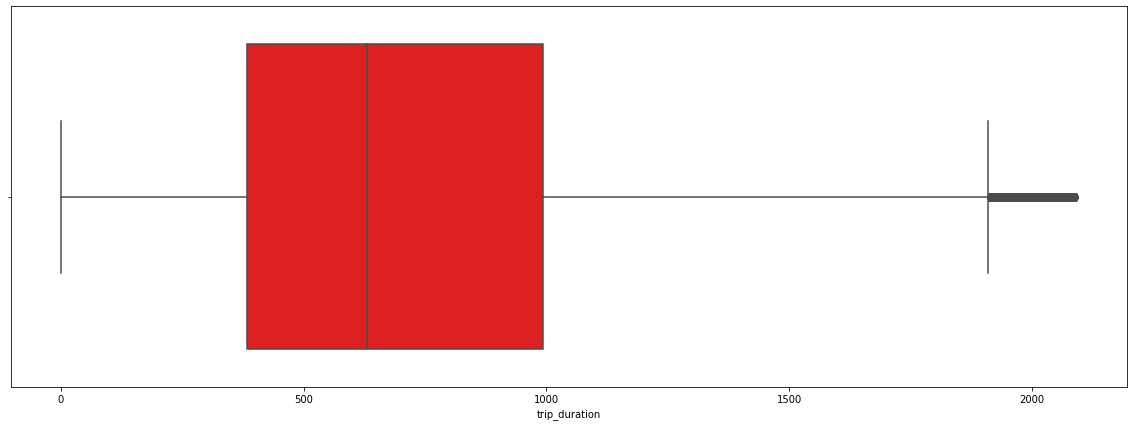

In [67]:
plt.figure(figsize= (20,7))
sns.boxplot(df['trip_duration'], color = 'red')

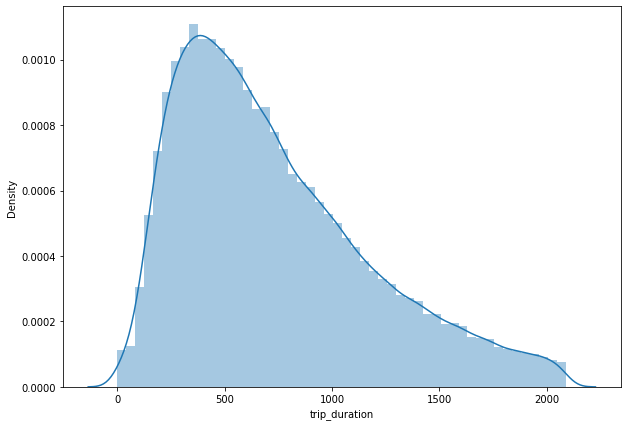

In [68]:
plt.figure(figsize= (10,7))
sns.distplot(df['trip_duration'])

In [69]:
df.columns

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'weekday', 'month'],
      dtype='object')

## distance

In [70]:
def calc_distance(df):
    pickup = (df['pickup_latitude'], df['pickup_longitude'])
    dropoff =  (df['dropoff_latitude'], df['dropoff_longitude'])
    distance1 = distance.distance(pickup, dropoff).km
    return distance1

df['distance'] = df.apply(lambda x: calc_distance(x), axis = 1)

df.drop(columns =['pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], inplace = True)

In [71]:
df.distance.sort_values(ascending= False)

94337    36.270120
23260    31.903800
23813    28.555760
57456    27.803536
31597    27.134757
           ...    
46375     0.000000
70269     0.000000
3042      0.000000
56286     0.000000
55866     0.000000
Name: distance, Length: 94939, dtype: float64

In [72]:
df[df['distance'] <= 0.01]

,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,weekday,month,distance
246,2,1,N,227,0,2,0.000000
291,2,2,N,1109,1,5,0.000000
323,1,1,N,40,0,6,0.003929
407,2,6,N,947,0,5,0.000000
702,1,1,N,580,0,1,0.000000
...,...,...,...,...,...,...,...
98616,2,2,N,32,3,3,0.000000
99063,2,1,N,217,0,2,0.000000
99627,2,1,N,610,2,4,0.000000
99635,1,1,N,6,5,5,0.000772


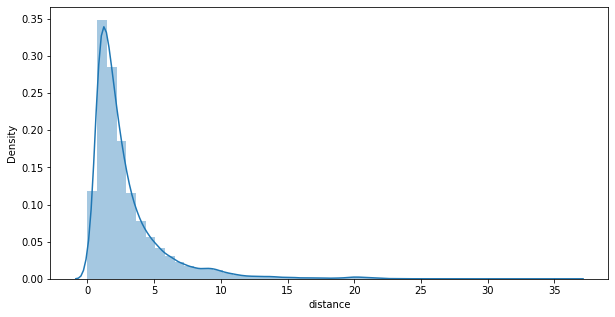

In [73]:
plt.figure(figsize= (10,5))
sns.distplot(df['distance'])

In [74]:
lower_limit, upper_limit = outlier_treatment(df['distance'])
print(f"upper limit = {upper_limit} \n lowe limit = {lower_limit}")

upper limit = 6.917667117080356 
 lowe limit = -2.232105402767377


In [75]:
# for removel of outliers we consider upper limit from our outlier-treatment function and for lower limit we use 0
df = df[(df['distance'] < upper_limit) & df['distance'] > 0]

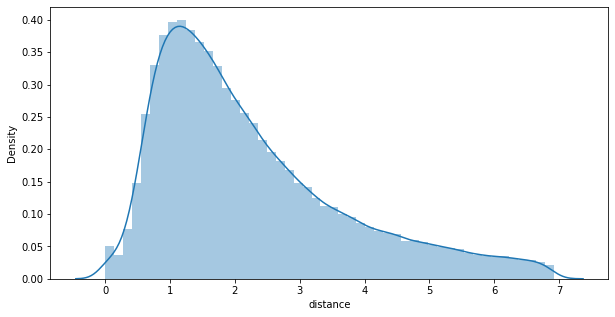

In [76]:
plt.figure(figsize= (10,5))
sns.distplot(df['distance'])

In [77]:
df[df['distance'] >= 8]

,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,weekday,month,distance


## number of passengers

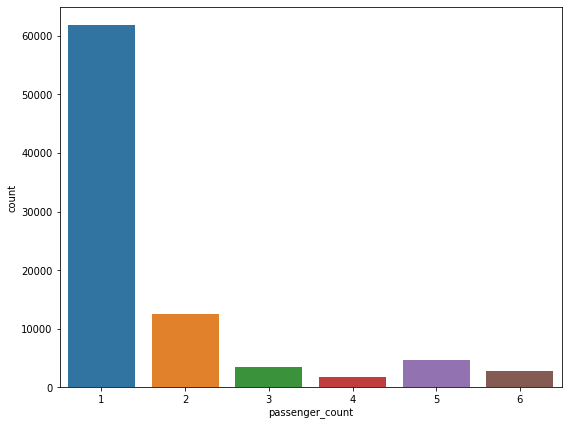

In [78]:
plt.figure(figsize=(9,7))
sns.countplot(df['passenger_count'])
plt.show()


* There are some wows with zero passengers we remove that columns
* we also remove the rows with more then 6 passengers considering the capacity of the cars


In [79]:
df = df[(df['passenger_count'] > 0) & (df['passenger_count'] <= 6)] 
df.passenger_count.value_counts().sort_index()

1    61837
2    12440
3     3500
4     1707
5     4756
6     2841
Name: passenger_count, dtype: int64

In [80]:
df.head().T

,0,1,3,4,5
vendor_id,2,1,2,2,2
passenger_count,1,1,1,1,6
store_and_fwd_flag,N,N,N,N,N
trip_duration,455,663,429,435,443
weekday,0,6,2,5,5
month,3,6,4,3,1
distance,1.502172,1.80866,1.483632,1.187038,1.099625


In [81]:
df.describe()

,vendor_id,passenger_count,trip_duration,weekday,month,distance
count,87081.000000,87081.000000,87081.000000,87081.000000,87081.000000,87081.000000
mean,1.531057,1.663635,670.958085,3.055098,3.496825,2.254128
std,0.499037,1.314963,398.535216,1.952819,1.678998,1.467803
min,1.000000,1.000000,1.000000,0.000000,1.000000,0.000424
25%,1.000000,1.000000,367.000000,1.000000,2.000000,1.154563
50%,2.000000,1.000000,589.000000,3.000000,3.000000,1.850877
75%,2.000000,2.000000,898.000000,5.000000,5.000000,2.988710
max,2.000000,6.000000,2091.000000,6.000000,6.000000,6.917639


In [82]:
df.columns

Index(['vendor_id', 'passenger_count', 'store_and_fwd_flag', 'trip_duration',
       'weekday', 'month', 'distance'],
      dtype='object')

In [83]:
df1.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

# Data preparation

In [89]:
# One hot encoding
df = pd.get_dummies(df, columns= ['vendor_id', 'passenger_count', 'store_and_fwd_flag', 'weekday', 'month'], drop_first= True)

In [90]:
df.columns

Index(['trip_duration', 'distance', 'vendor_id_2', 'passenger_count_2',
       'passenger_count_3', 'passenger_count_4', 'passenger_count_5',
       'passenger_count_6', 'store_and_fwd_flag_Y', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6'],
      dtype='object')

In [91]:
df.shape

(87081, 20)

In [95]:
dependent_variables = ['trip_duration']
independent_variables = [i for i in df.columns if i not in dependent_variables]

In [96]:
dependent_variables

['trip_duration']

In [104]:
independent_variables

['distance',
 'vendor_id_2',
 'passenger_count_2',
 'passenger_count_3',
 'passenger_count_4',
 'passenger_count_5',
 'passenger_count_6',
 'store_and_fwd_flag_Y',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6']

In [145]:
# get x and y values
X = df[independent_variables]
y = df[dependent_variables]

In [146]:
# Train Test Split.
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state =5)

In [147]:
# Scale the data 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model selection


**Models we will be building:**
* **Linear Regression**
* **Decision Tree Regressorr**
* **XG Boost Regressor**
* **Hist Gradient Boosting Regressor**


## 1. Linear Regression

In [180]:
# Applying Linear regression
lr = LinearRegression()
lr.fit(X_train,y_train)


LinearRegression()

In [181]:
y_pred = lr.predict(X_test)

In [182]:
 # Evelustion metrics Linear Regression
r2 = r2_score(y_test, y_pred)
MSE= mean_squared_error(y_pred, y_test)
RMSE = np.sqrt(MSE)
Adjusted_r2 = 1-(1-r2_score(y_test,y_pred))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))

print("R2 :" ,r2)
print("Adjusted R2 : ",Adjusted_r2)
print("MSE :" , MSE)
print("RMSE :" ,RMSE)

R2 : 0.4807125504176767
Adjusted R2 :  0.48014541461598303
MSE : 82859.40744294105
RMSE : 287.8531004574053


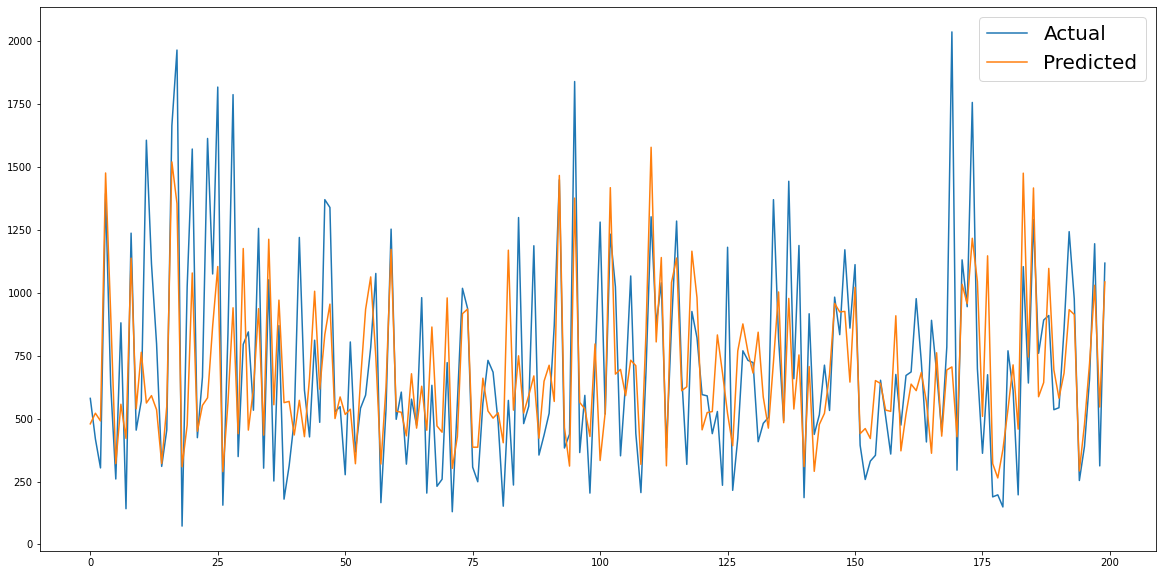

In [164]:
# Plotting actual and predicted values to find the difference
plt.figure(figsize = (20,10))
plt.plot(np.array(y_test[:200]))
plt.plot(np.array(y_pred[:200]))
plt.legend(["Actual","Predicted"],prop={'size': 20})
plt.show()

In [190]:
## Creating a function to to train different linear models
def train_linear_model(model, X_train , X_test, y_train, y_test):
    """ This function is used to train different linear models"""
    # Train the model 

    model.fit(X_train,y_train)

    # Predicting the values
    y_pred = model.predict(X_test)
    
    # Eveluation matrics 

    r2 = r2_score(y_test, y_pred)
    MSE= mean_squared_error(y_pred, y_test)
    RMSE = np.sqrt(MSE)
    Adjusted_r2 = 1-(1-r2_score(y_test,y_pred))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))

    print("\n \n")
    print("R2 :" ,r2)
    print("Adjusted R2 : ",Adjusted_r2)
    print("MSE :" , MSE)
    print("RMSE :" ,RMSE)

    print("\n \n")

    # Everluation graph
    plt.figure(figsize = (20,10))
    plt.plot(np.array(y_test[:200]))
    plt.plot(np.array(y_pred[:200]))
    plt.legend(["Actual","Predicted"],prop={'size': 20})
    plt.title("Everluation graph")
    plt.show()
    




 

R2 : 0.4807125504176767
Adjusted R2 :  0.48014541461598303
MSE : 82859.40744294105
RMSE : 287.8531004574053

 



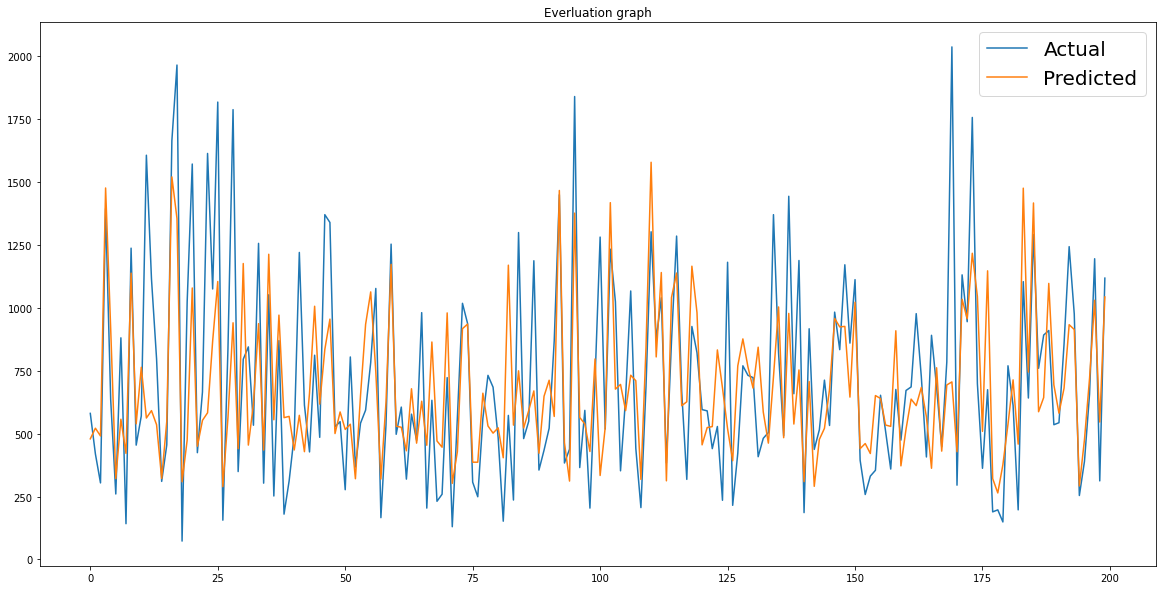

In [191]:
lr = LinearRegression()
train_linear_model(lr,X_train, X_test, y_train, y_test )

# Regularisation

## Lasso (L1)


 

R2 : 0.4807075170207018
Adjusted R2 :  0.4801403757218222
MSE : 82860.21059019813
RMSE : 287.85449551847915

 



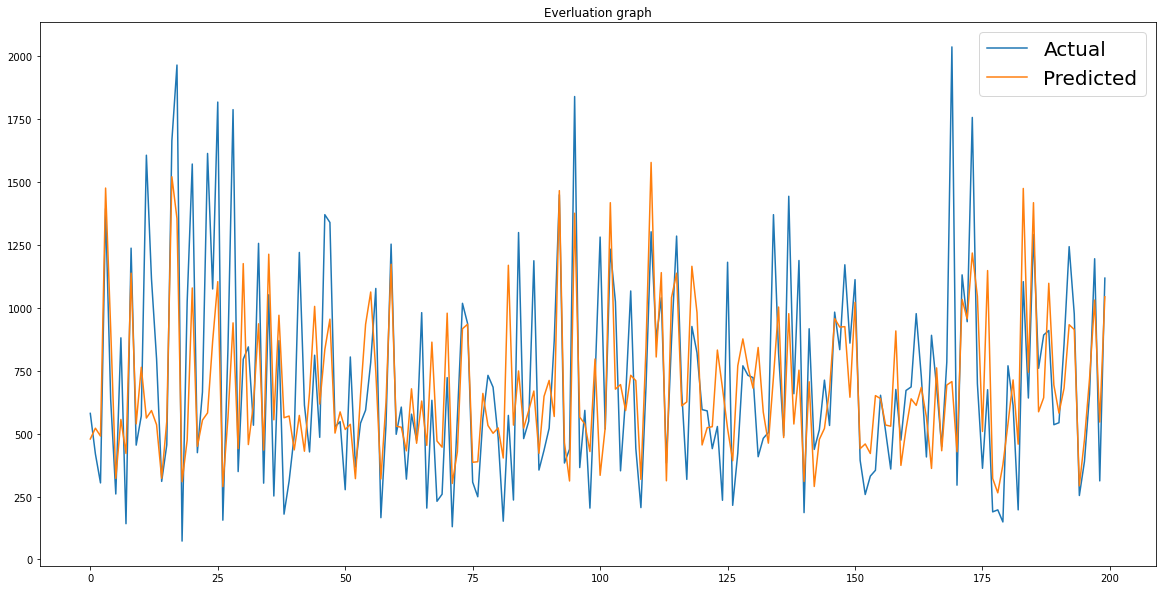

In [205]:
lasso_model = Lasso()
parameters = {'alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,60,100,0.0014]}
lasso_grid = GridSearchCV(lasso_model, parameters, scoring='neg_mean_squared_error', cv=5)
train_linear_model(lasso_grid,X_train, X_test, y_train, y_test )

## Ridge(l2)


 

R2 : 0.4807086914210509
Adjusted R2 :  0.48014155140478365
MSE : 82860.02319857698
RMSE : 287.8541700211706

 



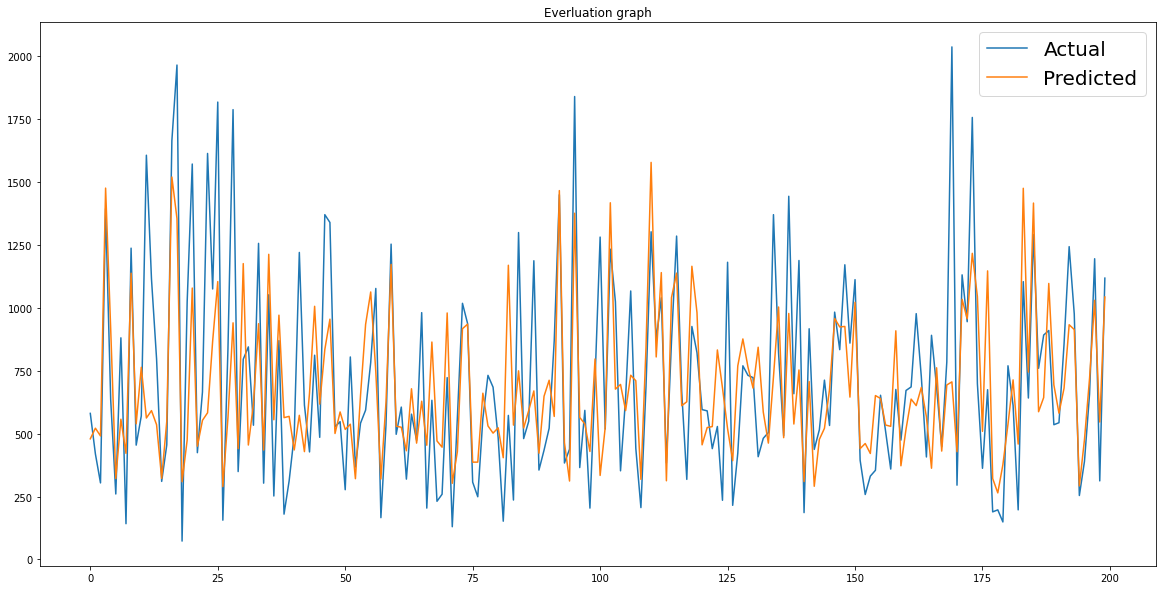

In [207]:
ridge_model = Ridge()
parameters = {'alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,60,100,0.0014]}
lasso_grid = GridSearchCV(ridge_model, parameters, scoring='neg_mean_squared_error', cv=5)
train_linear_model(lasso_grid,X_train, X_test, y_train, y_test )

## Elastic net


 

R2 : 0.4807084984603043
Adjusted R2 :  0.4801413582332965
MSE : 82860.05398810047
RMSE : 287.8542235022798

 



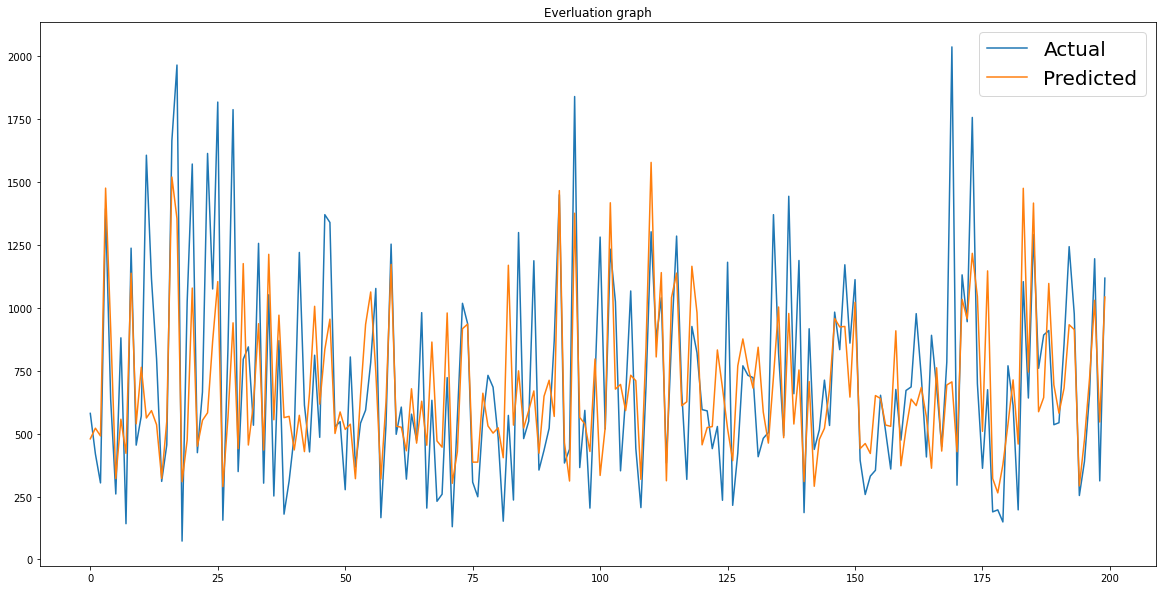

{'alpha': 0.001, 'l1_ratio': 0.4}

In [212]:
elastic = ElasticNet()
parameters = {'alpha': [1e-4,1e-3,1e-2,1e-1,1,5,10,200],'l1_ratio':[0.3,0.4,0.5,0.6,0.7]}
elastic_regressor = GridSearchCV(elastic, parameters, scoring='neg_mean_squared_error',cv=5)
train_linear_model(elastic_regressor,X_train, X_test, y_train, y_test )
elastic_regressor.best_params_